# Modified Type Classification of the OI Dataset

The dataset consist of information on the patient's age, sex, OI type and the landmark coordinates.

In this notebook we will be experimenting with various algorithms. Before we start we will need to prepare our data.

Patients will be grouped as follows 0 = control, 1 = types 1 and 4, 3 = type 3

In [2]:
import sklearn, csv
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load

In [3]:
# reading the csv file to a pandas dataframe
raw_df = pd.read_csv('oi_ml_db.csv')
oi_df = raw_df.drop(['Unnamed: 0', 'Genetic'], axis=1)
pd.DataFrame.head(oi_df)

,Group,File.No.,Age,Gender,1,2,3,4,5,6,...,127,128,129,130,131,132,133,134,135,136
0,1,247,9.75,F,-0.092029,-0.046122,-0.004750,0.036622,0.076192,0.111692,...,0.021580,0.038229,0.046834,0.017731,0.006984,-0.003919,-0.029018,-0.003609,0.007449,0.019253
1,1,248,46.00,M,-0.087255,-0.044113,-0.000605,0.042229,0.084390,0.121715,...,0.024153,0.043552,0.054324,0.022442,0.005124,-0.013601,-0.042180,-0.013968,0.004880,0.022075
2,1,117,9.50,M,-0.093099,-0.050187,-0.008432,0.032011,0.069601,0.101870,...,0.023409,0.043782,0.055508,0.019930,0.004186,-0.008934,-0.040112,-0.009088,0.004186,0.019930
3,1,118,4.50,F,-0.097396,-0.054587,-0.013650,0.026463,0.063994,0.095424,...,0.023868,0.040218,0.048534,0.019265,0.005838,-0.006880,-0.034215,-0.006766,0.007002,0.020429
4,1,10,16.50,M,-0.107241,-0.064653,-0.023025,0.018889,0.059456,0.093986,...,0.025020,0.041582,0.052597,0.021350,0.005461,-0.012100,-0.040288,-0.012100,0.005461,0.021350


In [4]:
# change the control group from 'c' to '0', '3' to '1' and '4' to '1'
oi_df = oi_df.replace({'Group':'c'}, 0)
oi_df = oi_df.replace({'Group':'4'}, 1)
# change M to 0 and F to 1
oi_df = oi_df.replace({'Gender':'M'}, 0)
oi_df = oi_df.replace({'Gender':'F'}, 1)
# we do not need the file.no anymore
oi_df = oi_df.drop(['File.No.'], axis=1)
# normalization of age
# oi_df = (oi_df-oi_df.mean())/oi_df.std()
pd.DataFrame.head(oi_df)

,Group,Age,Gender,1,2,3,4,5,6,7,...,127,128,129,130,131,132,133,134,135,136
0,1,9.75,1,-0.092029,-0.046122,-0.004750,0.036622,0.076192,0.111692,0.139643,...,0.021580,0.038229,0.046834,0.017731,0.006984,-0.003919,-0.029018,-0.003609,0.007449,0.019253
1,1,46.00,0,-0.087255,-0.044113,-0.000605,0.042229,0.084390,0.121715,0.153593,...,0.024153,0.043552,0.054324,0.022442,0.005124,-0.013601,-0.042180,-0.013968,0.004880,0.022075
2,1,9.50,0,-0.093099,-0.050187,-0.008432,0.032011,0.069601,0.101870,0.129200,...,0.023409,0.043782,0.055508,0.019930,0.004186,-0.008934,-0.040112,-0.009088,0.004186,0.019930
3,1,4.50,1,-0.097396,-0.054587,-0.013650,0.026463,0.063994,0.095424,0.121235,...,0.023868,0.040218,0.048534,0.019265,0.005838,-0.006880,-0.034215,-0.006766,0.007002,0.020429
4,1,16.50,0,-0.107241,-0.064653,-0.023025,0.018889,0.059456,0.093986,0.125210,...,0.025020,0.041582,0.052597,0.021350,0.005461,-0.012100,-0.040288,-0.012100,0.005461,0.021350


In [5]:
# shuffle the dataframe
rand_df = sklearn.utils.shuffle(oi_df)

# create the complete y and X sets from the shuffled data and scale the X values
X_full = rand_df.drop(['Group'], axis=1)
y_full = rand_df['Group']
X_full = preprocessing.scale(X_full)

# PCA for dimensional reduction of our data 138 features to 10 features
pca = PCA(n_components=30)
pComp = pca.fit_transform(X_full)

# splitting X and y for train and test 80/20
X_sets = np.split(pComp, [245, 61])
X_train = pComp[0:245,]
X_test = pComp[245:306,]
y_train = y_full.values[0:245,]
y_test = y_full.values[245:306,]

# cast y values as integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print('train set: ' + str(X_train.shape) + '\ntest set: ' + str(X_test.shape))

train set: (245, 30)
test set: (61, 30)


In [6]:
# Multi Layer Perceptron (AKA: shallow neural network)
# more sofisticated classifier but may tend to overfit
mlp = MLPClassifier(hidden_layer_sizes=(30,), max_iter=10, alpha=1e-4, solver='sgd', 
                    verbose=10, tol=1e-4, random_state=1, learning_rate_init=.1)
mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

# modified type classification seems to be working very well for this dataset with a PCA of 30 components

Iteration 1, loss = 2.25606711
Iteration 2, loss = 0.64756797
Iteration 3, loss = 0.37976781
Iteration 4, loss = 0.22807478
Iteration 5, loss = 0.18119940
Iteration 6, loss = 0.13505184
Iteration 7, loss = 0.07828618
Iteration 8, loss = 0.06385615
Iteration 9, loss = 0.05463999
Iteration 10, loss = 0.04841652
Training set score: 1.000000
Test set score: 0.901639


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [7]:
# Linear Support Vector Machine
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X_train, y_train)
pred = svm_clf.predict(X_test)
right = 0
wrong = 0
index = 0
for p in pred:
    if p == y_test[index]:
        right += 1
    if pred[index] != y_test[index]:
        wrong += 1
    index += 1
print('Test score: ' + str(right/61) + '%')

# the linear support vector machine seems to be performing similarily to the NN 

Test score: 0.9180327868852459%


In [8]:
# Logistic regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
lr_clf.score(X_test, y_test)

# great performance with PCA of 30

0.9836065573770492

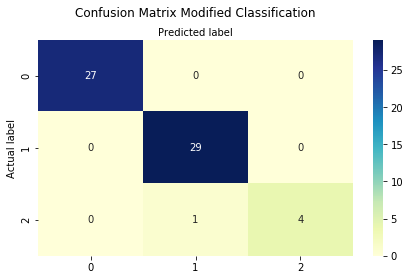

In [10]:
# confusion matrix
y_pred = lr_clf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.title("Confusion Matrix Modified Classification", y=1.08)
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('conf_mat_mod.png')
plt.show()

In [11]:
# save the model with joblib
dump(lr_clf, 'mod_clf.joblib') 

['mod_clf.joblib']

In [13]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        27
          1       0.97      1.00      0.98        29
          3       1.00      0.80      0.89         5

avg / total       0.98      0.98      0.98        61

